# Grading process


The submission notebook will be autovalidated with `papermill`. The exact command is the following:

```bash
papermill <notebook-name>.ipynb <notebook-name>-run.ipynb .ipynb -p TEST True
```

Papermill will inject new cell after each cell tagged as `parameters` (see `View > Cell toolbar > Tags`). Notebook will be executed from top to bottom in a linear order. `solutions.py` contains correct implementations used to validate your solutions.

Please, **fill `STUDENT` variable with the name of submitting student**, so that we can collect the results automatically. Please, **do not change `TEST` variable** and `validation` cells. If you need to inject your own code for testing, wrap it into

```python
if not TEST:
    ...
```

Different problems give different number of points. All problems in the basic section give 1 point, while all problems in intermediate section give 2 points.

Each problem contains specific validation details. You need to fill each cell tagged `solution` with your code. Note, that solution function must self-contained, i.e. it must not use any state from the notebook itself.

# Dataset

All problems in the assignment use [electricity load dataset](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014). Some functions/methods accept data itself, and in that case it's a Pandas dataframe as obtained by

```python
df = pd.read_csv("LD2011_2014.txt",
                 parse_dates=[0],
                 delimiter=";",
                 decimal=",")
df.rename({"Unnamed: 0": "timestamp"}, axis=1, inplace=True)
```

In contrast, whenever a function/method accepts a filename, it's the filename of **unzipped** data file (i.e. `LD2011_2014.txt`). When testing, do not rely on any specific location of the dataset, as validation environment will most certainly different from your local one. Hence, calls like

```python
df = pd.read_csv("<your-local-directory>/LD2011_2014.txt")
```

will fail.

In [2]:
import numpy as np
import pandas as pd
import torch

In [3]:
STUDENT = "Noam Salomonski"

In [4]:
ASSIGNMENT = 1
TEST = False

In [5]:
if TEST:
    import solutions
    total_grade = 0
    MAX_POINTS = 12

# Pandas

### 1. Resample the dataset (1 point)

Resample the dataset to 1-hour resolution. Use `mean` as an aggregation function. Your function must output a dataframe, with the same structure as the original one (i.e. not indexed by datetime).

In [28]:
if not TEST:
    orig_df = pd.read_csv("LD2011_2014.txt",
                 parse_dates=[0],
                 delimiter=";",
                 decimal=",")
    orig_df.rename({"Unnamed: 0": "timestamp"}, axis=1, inplace=True)
    print(orig_df.head())

            timestamp  MT_001  MT_002  MT_003  MT_004  MT_005  MT_006  MT_007  \
0 2011-01-01 00:15:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1 2011-01-01 00:30:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2 2011-01-01 00:45:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3 2011-01-01 01:00:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4 2011-01-01 01:15:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   MT_008  MT_009  ...  MT_361  MT_362  MT_363  MT_364  MT_365  MT_366  \
0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
1     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
3     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
4     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

   MT_367  MT_368  MT_369  MT_370  
0     0.0     0.0     0.0     0.

In [44]:
def el_resample(df):
    # your code goes here
    #print(df.head())
    #print(df.index)
    #print(df["timestamp"].dtype)
    df = df.resample('H',on='timestamp').mean().reset_index()
    #print(df.head())
    #print(df.index)
    return df

if not TEST:
    el_resample(orig_df.copy())

In [ ]:
PROBLEM_ID = 1

if TEST:
    total_grade += solutions.check(STUDENT, PROBLEM_ID, el_resample)

### 2. Consumption peaks (1 point)

For each household, calculate, which month in 2014 had the highest consumption. Your function must output series, indexed by household ID (e.g., `MT_XXX`), and containing month as an integer (`1-12`).

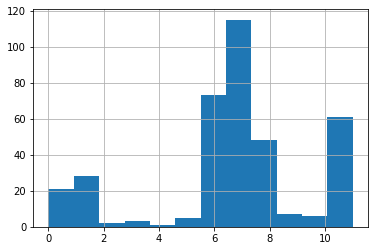

In [91]:
def cons_peak(df):
    #print(df.head())
    #print(df.index)
    df2014 = df[df["timestamp"].dt.year == 2014]
    months2014 = df2014.resample('M',on='timestamp').mean().reset_index()
    #print(months2014)
    #print(f"len = {len(months2014)}")
    max_month = months2014.drop(["timestamp"], axis=1).idxmax(axis=0)
    #print("max_month:")
    #print(max_month)
    #max_month.hist(bins=12)
    return max_month

if not TEST:
    cons_peak(orig_df.copy())

In [ ]:
PROBLEM_ID = 2

if TEST:
    total_grade += solutions.check(STUDENT, PROBLEM_ID, cons_peak)

# PyTorch

### 3. Find minimum (2 points)

Consider the following scalar function:

$$
f(x) = ax^2 + bx + c
$$

Given $a,b,c$, find $x$, which minimizes $f(x)$, and minimum value of $f(x)$. Note this:

- $a,b,c$ are fixed, and generated in such a way, that minimum always exists ($f(x)$ is convex),
- $x$ is a scalar value, i.e. 0-dimensional tensor.

For reference, see `generate_coef` function, which is used to generate coefficients. Note, that since optimization process is not completely deterministic, the output is considered correct, if it falls within `1e-3` of actual values.

This problem must be solved as an optimization one using gradient descent.

For that, use only PyTorch functionality, `SciPy` (or alike) optimization routines are not allowed, neither is direct calculation using coefficients.

In [82]:
def generate_coeffs():
    a = torch.rand(size=()) * 10
    b = -10 + torch.rand(size=()) * 10
    c = -10 + torch.rand(size=()) * 10
    return a, b, c

def func(x, a, b, c):
    return x.pow(2) * a + x * b + c

In [ ]:
def find_min(a, b, c):
    param = torch.zeros(size=(), requires_grad=True)
    value_function = lambda x :func(x, a, b, c)
    loss_function = lambda val: val

    optimizer = torch.optim.SGD([param], lr=0.01, momentum=0.9)
    for _ in range(10000):
        optimizer.zero_grad()
        value = value_function(param)
        loss = loss_function(value)
        loss.backward()
        optimizer.step()

    x_min = param
    val_min = value_function(x_min)

    return x_min, val_min

if not TEST:
    for _ in range(100):
        a, b, c = generate_coeffs()
        x_min, val_min = find_min(a, b, c)
        print(f"a={a}, b={b}, c={c}, x_min={x_min}, val_min={val_min}")

        analytic_solution_x = torch.tensor(-b / (2*a))
        analytic_solution_val = func(analytic_solution_x, a, b, c)

        np.testing.assert_almost_equal(analytic_solution_x, x_min.detach().numpy(), decimal=4),
        np.testing.assert_almost_equal(analytic_solution_val, val_min.detach().numpy(), decimal=4)

a=4.548792839050293, b=-4.888336181640625, c=-1.2198171615600586, x_min=0.5373223423957825, val_min=-2.533123254776001
a=8.883511543273926, b=-1.923283576965332, c=-3.6016411781311035, x_min=0.10825017839670181, val_min=-3.7057390213012695
a=2.3482303619384766, b=-6.40963077545166, c=-8.601326942443848, x_min=1.364778995513916, val_min=-12.975191116333008
a=2.369340658187866, b=-8.5217924118042, c=-7.960484504699707, x_min=1.7983468770980835, val_min=-15.623054504394531
a=4.64476203918457, b=-6.6870222091674805, c=-0.2980365753173828, x_min=0.7198455333709717, val_min=-2.704848051071167


c:\noam\ydata_timeseries_course\venv\lib\site-packages\ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
PROBLEM_ID = 3

if TEST:
    total_grade += solutions.check(STUDENT, PROBLEM_ID, find_min)

### 4. PyTorch `Dataset` (3 points)

Implement a `torch.utils.data.Dataset` sub-class for the electricity consumption data. Individual training instances must be week-long univarite series of hourly consumption (input, 168 values), followed by 24-hours long series of hourly consumption (output, 24 values) for a single household. Such a class can be used when training a consumption forecast model, which uses 7 days of historical consumption to forecast next 24 hours of consumption.

`__getitem__(self, idx)` must return a tuple of 1D tensors, `in_data` and `out_data`. `in_data` contains 168 hours of consumption (hourly), starting from some `start_ts`, while `out_data` must contain 24 hourly consumption values starting from `start_ts + 168 hours` for some household. `start_ts` should be sampled randomly.

Also, you need to implement a `get_mapping(self, idx)` method, which allows to calculate `(household, starting time) -> idx` correspondence.

This class will be validated as the following:

- dataset object is created with some random `samples`: `dataset = ElDataset(df, samples)` ,
- validator fetches random `idx` (between `0` and `len(dataset)`) from the dataset:
```python
household, start_ts = dataset.get_mapping(idx)
hist_data, future_data = dataset[idx]
```
- then, `hist_data` and `future_data` are compared with the data, obtained directly from `df` using `household, start_ts`.

In [ ]:
from torch.utils.data import Dataset


class ElDataset(Dataset):
    """Electricity dataset."""

    def __init__(self, df, samples):
        """
        Args:
            df: original electricity data (see HW intro for details).
            samples (int): number of sample to take per household.
        """
        self.raw_data = df.set_index("")
        self.samples = samples

    def __len__(self):
        return self.samples * (self.raw_data.shape[1] - 1)

    def __getitem__(self, idx):
        # your code goes here
        # return hist_data, future_data
        raise NotImplementedError

    def get_mapping(self, idx):
        # your code goes here
        # return household, start_ts
        raise NotImplementedError

In [ ]:
PROBLEM_ID = 4

if TEST:
    total_grade += solutions.check(STUDENT, PROBLEM_ID, ElDataset)

# Your grade

In [ ]:
if TEST:
    print(f"{STUDENT}: {total_grade}")